#1.Load Data

In [ ]:
import pandas as pd

In [ ]:
import re

In [ ]:
df = pd.read_csv('/content/livestream_comments_1000.csv')

In [ ]:
df.head()

,comment,label
0,Ai xem cùng không???,Spam / Không liên quan
1,Spam icon 😂😂😂,Spam / Không liên quan
2,Hàng chất lượng nè,Khen ngợi / Tương tác tích cực
3,Có màu trắng không bạn?,Hỏi thông tin sản phẩm
4,Shop rep nhanh giúp,Khẩn cấp / Cần phản hồi nhanh


#2.Preprocces Data

In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r"http\S+|www\S+","",text)
  text = re.sub(r"\d+","",text)
  text = re.sub(r"[^\w\s]","",text)
  text = re.sub(r"\s+"," ",text).strip()
  return text

In [ ]:
df["comment"]=df["comment"].apply(clean_text)

In [ ]:
df.head()

,comment,label
0,ai xem cùng không,Spam / Không liên quan
1,spam icon,Spam / Không liên quan
2,hàng chất lượng nè,Khen ngợi / Tương tác tích cực
3,có màu trắng không bạn,Hỏi thông tin sản phẩm
4,shop rep nhanh giúp,Khẩn cấp / Cần phản hồi nhanh


#3.EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("so comment",len(df))
print("so luong nhan", df["label"].unique())
print("so luong nhan gia tri duy nhat",df["label"].nunique())


so comment 1000
so luong nhan ['Spam / Không liên quan' 'Khen ngợi / Tương tác tích cực'
 'Hỏi thông tin sản phẩm' 'Khẩn cấp / Cần phản hồi nhanh'
 'Hỏi vận chuyển / Thanh toán' 'Hỏi giá' 'Phàn nàn / Tiêu cực'
 'Chốt đơn / Mua hàng']
so luong nhan gia tri duy nhat 8


In [ ]:
label_count = df["label"].value_counts()
print(label_count)


label
Hỏi thông tin sản phẩm            148
Khẩn cấp / Cần phản hồi nhanh     137
Khen ngợi / Tương tác tích cực    134
Chốt đơn / Mua hàng               126
Phàn nàn / Tiêu cực               120
Spam / Không liên quan            119
Hỏi vận chuyển / Thanh toán       119
Hỏi giá                            97
Name: count, dtype: int64


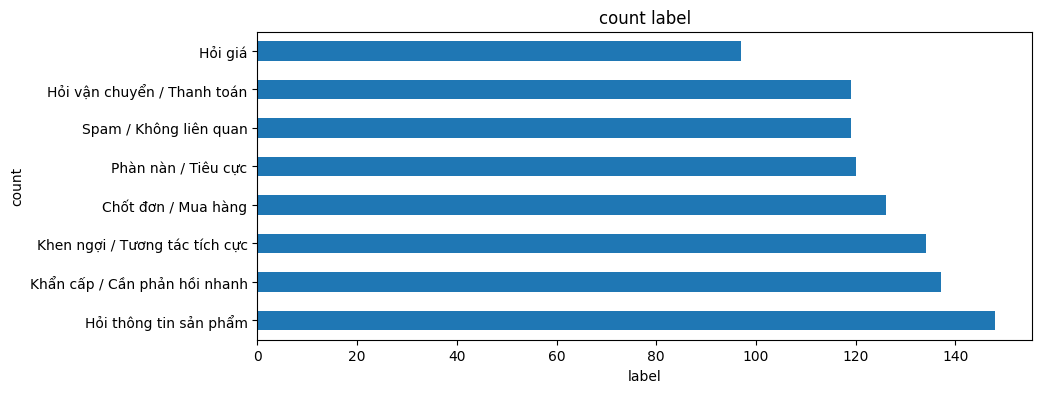

In [ ]:
plt.figure(figsize=(10,4))
label_count.plot(kind='barh')
plt.xlabel("label")
plt.ylabel("count")
plt.title("count label")
plt.show()


In [ ]:
df["lenght"]=df["comment"].apply(lambda x:len(str(x).split()))

In [ ]:
df.head()

,comment,label,lenght
0,ai xem cùng không,Spam / Không liên quan,4
1,spam icon,Spam / Không liên quan,2
2,hàng chất lượng nè,Khen ngợi / Tương tác tích cực,4
3,có màu trắng không bạn,Hỏi thông tin sản phẩm,5
4,shop rep nhanh giúp,Khẩn cấp / Cần phản hồi nhanh,4


In [ ]:

df["lenght"].describe()

,lenght
count,1000.000000
mean,4.011000
std,1.257163
min,0.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,7.000000


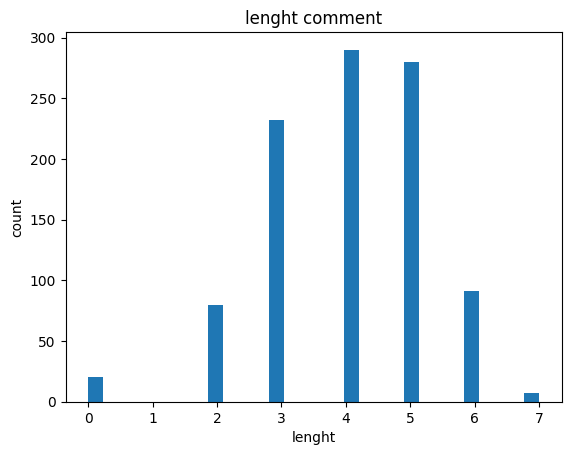

In [ ]:
plt.hist(df["lenght"],bins=30)
plt.title("lenght comment")
plt.xlabel("lenght")
plt.ylabel("count")
plt.show()

In [ ]:
from collections import Counter


In [ ]:
all_words= " ".join(df["comment"]).split()
word_pred = Counter(all_words).most_common(20)
print("20 common",word_pred)


20 common [('không', 248), ('có', 165), ('shop', 161), ('mình', 157), ('cho', 108), ('vậy', 88), ('hàng', 81), ('cái', 75), ('sản', 72), ('phẩm', 72), ('này', 69), ('giá', 67), ('nhiêu', 67), ('giao', 66), ('quá', 63), ('size', 60), ('rep', 57), ('gấp', 57), ('bao', 55), ('thế', 54)]


#5.Encoder

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels=df["label"].unique()
label2id={label:i for i ,label in enumerate(labels)}
id2label={i: label for label , i in label2id.items()}


In [ ]:
df["label_id"]=df["label"].map(label2id)

#6.Prepare Data for train

In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

In [ ]:
train_df,test_df= train_test_split(df,test_size=0.2,stratify=df["label_id"],random_state=42)

In [ ]:
train_dataset=Dataset.from_pandas(train_df)
test_dataset=Dataset.from_pandas(test_df)

In [ ]:
# chỉ giữ các cột cần thiết
train_dataset = Dataset.from_pandas(train_df[["comment", "label_id"]])
test_dataset = Dataset.from_pandas(test_df[["comment", "label_id"]])
train_dataset = train_dataset.remove_columns("__index_level_0__")
test_dataset = test_dataset.remove_columns("__index_level_0__")


def preprocess(batch):
    encoding = tokenizer(
        batch["comment"],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    # Ensure label_id is cast to torch.long and rename it to labels
    encoding["labels"] = torch.tensor(batch["label_id"], dtype=torch.long)
    return encoding

In [ ]:
print(train_dataset)

Dataset({
    features: ['comment', 'label_id'],
    num_rows: 800
})


In [ ]:
train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
num_label=len(label2id)
model=AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_label,id2label=id2label,label2id=label2id)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids                    # numpy array
    preds = np.argmax(pred.predictions, axis=1) # numpy array
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}


In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


#6.Train

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import evaluate

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-2147312783.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thuannauht (thuannauht-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.959600,1.659811,0.675000,0.625750,0.644429
2,1.632400,1.276934,0.955000,0.955101,0.955369
3,1.390500,1.113984,0.955000,0.955101,0.955369


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=150, training_loss=1.6608158365885417, metrics={'train_runtime': 7104.2086, 'train_samples_per_second': 0.338, 'train_steps_per_second': 0.021, 'total_flos': 315750275481600.0, 'train_loss': 1.6608158365885417, 'epoch': 3.0})

#7.Evaluate

In [ ]:
metrics = trainer.evaluate()
print(metrics)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.1139836311340332, 'eval_accuracy': 0.955, 'eval_f1_macro': 0.9551008809320829, 'eval_f1_weighted': 0.9553694231315714, 'eval_runtime': 196.1113, 'eval_samples_per_second': 1.02, 'eval_steps_per_second': 0.066, 'epoch': 3.0}


#8.Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/my_models/my_model"

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/drive/MyDrive/my_models/my_model/tokenizer_config.json',
 '/content/drive/MyDrive/my_models/my_model/special_tokens_map.json',
 '/content/drive/MyDrive/my_models/my_model/vocab.txt',
 '/content/drive/MyDrive/my_models/my_model/bpe.codes',
 '/content/drive/MyDrive/my_models/my_model/added_tokens.json')

#9.Test Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/my_models/my_model")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/my_models/my_model")


In [ ]:
print("Số nhãn:", model.config.num_labels)
print("Mapping id2label:", model.config.id2label)
print("Mapping label2id:", model.config.label2id)


Số nhãn: 8
Mapping id2label: {0: 'Spam / Không liên quan', 1: 'Khen ngợi / Tương tác tích cực', 2: 'Hỏi thông tin sản phẩm', 3: 'Khẩn cấp / Cần phản hồi nhanh', 4: 'Hỏi vận chuyển / Thanh toán', 5: 'Hỏi giá', 6: 'Phàn nàn / Tiêu cực', 7: 'Chốt đơn / Mua hàng'}
Mapping label2id: {'Chốt đơn / Mua hàng': 7, 'Hỏi giá': 5, 'Hỏi thông tin sản phẩm': 2, 'Hỏi vận chuyển / Thanh toán': 4, 'Khen ngợi / Tương tác tích cực': 1, 'Khẩn cấp / Cần phản hồi nhanh': 3, 'Phàn nàn / Tiêu cực': 6, 'Spam / Không liên quan': 0}


In [ ]:
import torch

def predict_text(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
    return model.config.id2label[pred_id]

# Ví dụ
text = "Shop ơi, sản phẩm này còn hàng không?"
print("Predicted label:", predict_text(model, tokenizer, text))


Predicted label: Hỏi thông tin sản phẩm
